In [1]:
%cd ..

/Users/heilman/galvanize/recipe-vectorizer


In [4]:
from src.functions import *
from src.modeling_functions import *
import numpy as np
import networkx as nx
import pandas as pd
from collections import Counter
from string import *
from sklearn.metrics.pairwise import cosine_similarity
from sys import argv, exit
import pymongo
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import imageio
import time
import warnings
warnings.filterwarnings("ignore")

In [16]:
def plot_weighted_graph(G, ax, k=0.5, fixed_axes=None):

    betweenness = nx.edge_betweenness_centrality(G)
    between_array = np.array([val for key, val in betweenness.items()])
    edge_colors = [cm.jet(bet/np.max(between_array)) for bet in between_array]

    spring = nx.spring_layout(G, k=k, weight='weight', seed=427)
    
    for subG in nx.connected_component_subgraphs(G):
        eigen_centralities = nx.eigenvector_centrality(subG)
        eigen_array = np.array([val for key, val in eigen_centralities.items()])
        node_colors = [cm.jet(eig/np.max(eigen_array)) for eig in eigen_array]
        nx.draw_networkx_nodes(subG,
                               pos=spring,
                               node_size=50 * eigen_array/np.max(eigen_array) + 10,
                               node_color=node_colors,
                               ax=ax,
                               alpha=0.5,
                               with_labels=False)
    nx.draw_networkx_edges(G,
                           pos=spring,
                           edge_color=edge_colors,
                           width=8 * between_array/np.max(between_array) + 0.1,
                           alpha=0.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if fixed_axes:
        ax.set_xlim(left=fixed_axes[0], right=fixed_axes[1])
        ax.set_ylim(bottom=fixed_axes[2], top=fixed_axes[3])

In [39]:
search_term = 'thai curry'
n_recipes = 6

min_cluster_size = 10

mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

print('Searching for {} recipes...'.format(search_term))
recipes, ratings = find_recipes_matching_search(recipes_coll, search_term)
print('{} recipes found.'.format(len(recipes)))

df = create_dataframe(recipes)
X = df.values
cosine_sims = cosine_similarity(X)

G = create_graph(cosine_sims, threshold=0.85)
remove_isolates(G, min_cluster_size)

graphs = [G.copy()]
n_subgraphs = nx.number_connected_components(G)
print('{} clusters identified.'.format(n_subgraphs))
while n_subgraphs < n_recipes:
    largest_subgraph = max(nx.connected_component_subgraphs(G), key=len)
    graphs += split_subgraph(largest_subgraph, G, return_history=True)
    remove_isolates(G, min_cluster_size)
    new_n = nx.number_connected_components(G)
    if n_subgraphs < new_n:
        print('{} clusters identified.'.format(new_n))
    n_subgraphs = new_n
    if len(G) <= min_cluster_size:
        break

recipe_names_in_cluster = []
for component in nx.connected_components(G):
    recipe_names_in_cluster.append(get_recipe_names(component, df.index, recipes))

cluster_keywords = []
for names in recipe_names_in_cluster:
    cluster_keywords.append(find_keywords(names, limit=4))

recipe_results = generate_recipes(G, df)

for i, r in enumerate(recipe_results):
    print('\nRecipes in cluster (5 of {}) :'.format(len(recipe_names_in_cluster[i])))
    print(recipe_names_in_cluster[i][:5])
    print('\nCluster keywords :')
    print(cluster_keywords[i])
    print('\nSuggested recipe :')
    print(r)
    print('--------------------------------')

Searching for thai curry recipes...
440 recipes found.
4 clusters identified.
5 clusters identified.
6 clusters identified.

Recipes in cluster (5 of 122) :
['Red Curry Chicken Chili', 'Curry Stand Chicken Tikka Masala Sauce', 'Curried Coconut Chicken', "Chef John's Peanut Curry Chicken", 'Panang Curry with Chicken']

Cluster keywords :
[('chicken', 97), ('thai', 69), ('curry', 62), ('coconut', 8)]

Suggested recipe :
chicken          5.111976
garlic           0.158748
onion            0.730708
coconut milk     1.544848
ginger           0.042908
curry powder     0.027754
cilantro         0.152717
fish sauce       0.053467
vegetable oil    0.052900
salt             0.008542
water            0.759059
soy sauce        0.064370
green onion      0.140431
white sugar      0.040549
bell pepper      0.448368
olive oil        0.040071
lime juice       0.025676
chicken broth    0.440703
carrot           0.284294
brown sugar      0.039791
dtype: float64
--------------------------------

Recipes i

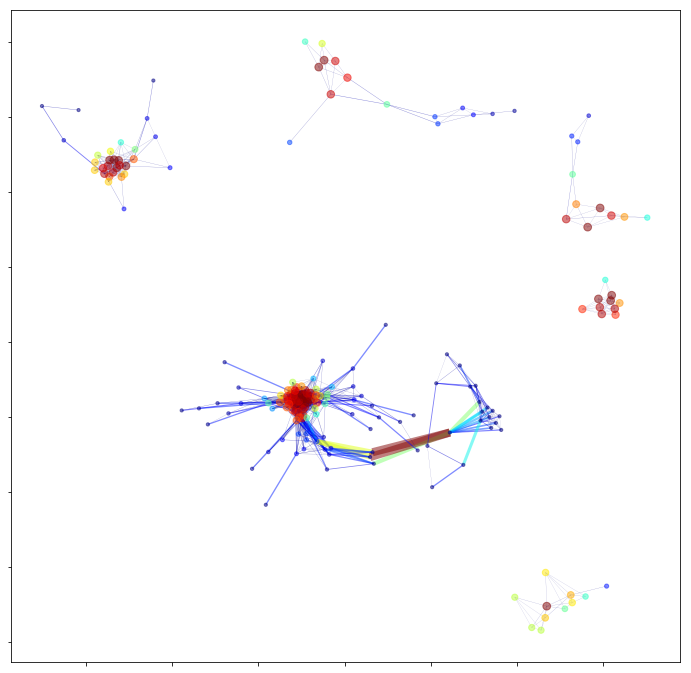

In [40]:
fig, ax = plt.subplots(figsize=(12,12))
plot_weighted_graph(G, ax, k=0.5)

In [30]:
len(graphs)

28

In [33]:
frames = []
print('0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%')
print('|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|')
for i,graph in enumerate(graphs):
    pct = int((i/len(graphs)) * 100)
    print('|{0}{1}| {2}% complete'.format('='*pct, '.'*(99-pct),pct), end='\r')
    fig, ax = plt.subplots(figsize=(12,12))
    plot_weighted_graph(graph, ax, k=0.5, fixed_axes=(-1.00, 1.00, -1, 1))
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    frames.append(img)
    if i==0 or i==len(graphs)-1:
        for _ in range(10):
            frames.append(img)
    pct = int(((i+1)/len(graphs)) * 100)
    s = '='*pct if pct != 100 else '='*99
    print('|{0}{1}| {2}% complete'.format(s, '.'*(99-pct),pct), end='\r')
    
imageio.mimsave('images/thai-curry-3.gif', frames, duration=0.2)

0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%
|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|
